In [ ]:
import sys
sys.path.insert(0, '/home/tomma/litebird/litebird_sim_clone/litebird_sim')
import litebird_sim as lbs
import numpy as np
import healpy as hp
from dataclasses import asdict
import matplotlib.pyplot as plt

In [51]:
nside = 512
mission_time_is_sec = 24*3600
instrument = "MFT"
channel = "M1-140"
sampling = 1 # this replaces channelinfo.sampling_rate_hz

In [52]:
imo = lbs.Imo()
sim = lbs.Simulation(base_path="./tutorial",
                     start_time=0,
                     duration_s=mission_time_is_sec,
                    )

In [53]:
mft_file = sim.imo.query("/releases/v1.0/satellite/"+instrument+"/instrument_info")
sim.generate_spin2ecl_quaternions(imo_url="/releases/v1.0/satellite/scanning_parameters/")
instrumentinfo = lbs.InstrumentInfo(name=instrument, 
    boresight_rotangle_rad=np.deg2rad(mft_file.metadata["boresight_rotangle_deg"]),
    spin_boresight_angle_rad=np.deg2rad(mft_file.metadata["spin_boresight_angle_deg"]),
    spin_rotangle_rad=np.deg2rad(mft_file.metadata["spin_rotangle_deg"]),
    )
channelinfo = lbs.FreqChannelInfo.from_imo(
    url="/releases/v1.0/satellite/"+instrument+"/"+channel+"/channel_info",
    imo=imo,
    )
hwp_radpsec = mft_file.metadata["hwp_rpm"]*2.0*np.pi/60.0

In [54]:
dets=[]
detquats=[]
#for detname in channelinfo.detector_names[0:20]:
for detname in channelinfo.detector_names:
    det=lbs.DetectorInfo.from_imo(
        url="/releases/v1.0/satellite/"+instrument+"/"+channel+"/"+detname+"/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = sampling
    dets.append(det)
    detquats.append(det.quat)

## Fill tod and then build map

In [56]:
obs, = sim.create_observations(detectors=dets)

pointings = lbs.scanning.get_pointings(obs,
                                       spin2ecliptic_quats=sim.spin2ecliptic_quats,
                                       detector_quats=detquats,
                                       bore2spin_quat=instrumentinfo.bore2spin_quat,
                                      )

In [57]:
Mbsparams = lbs.MbsParameters(make_cmb =True,
                              make_fg = True,
                              gaussian_smooth = True,
                              bandpass_int = False,
                              nside = nside,
                             )

mbs = lbs.Mbs(simulation=sim,
              parameters=Mbsparams,
              channel_list=channelinfo,
             )
maps = mbs.run_all()[0][channel]

[2021-11-22 18:12:14,708 INFO MPI#0000] generating and saving cmb simulations


***************** D
***************** D
***************** D


[2021-11-22 18:12:39,258 INFO MPI#0000] generating and saving fg simulations


AttributeError: 'NoneType' object has no attribute 'keys'

In [33]:
hwp_sys = lbs.HwpSys(sim)
hwp_sys.set_parameters(maps=maps,
                       integrate_in_band=False,
                       correct_in_solver=False,
                       built_map_on_the_fly=False,
                       nside=nside,
                      )

In [34]:
hwp_sys.fill_tod(obs,pointings,hwp_radpsec)
obs.tod *= 2.0 #

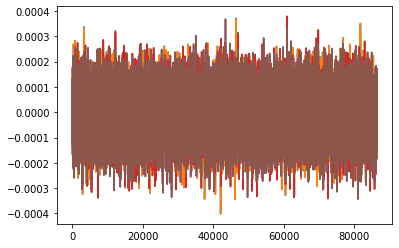

In [46]:
plt.plot(obs.tod[0])
plt.plot(obs.tod[1])
plt.plot(obs.tod[2])
plt.plot(obs.tod[3])
plt.plot(obs.tod[4])
plt.plot(obs.tod[5])
#plt.xlim(0,100)

In [47]:
m = lbs.make_bin_map([obs],nside).T

/home/tomma/.local/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/home/tomma/.local/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/home/tomma/.local/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been de

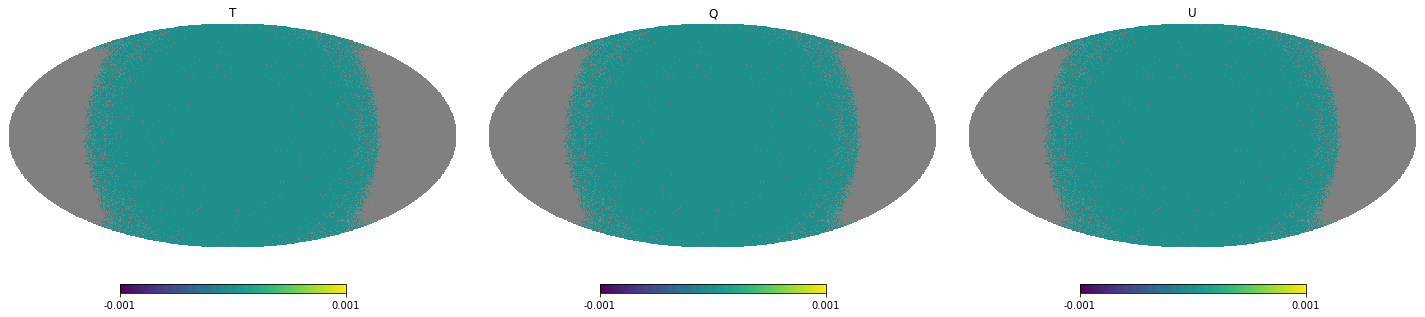

In [14]:
fig = plt.figure(figsize=(20,10))
hp.mollview(m[0]-maps[0],sub=131,title='T',min=-1e-3,max=1e-3)
hp.mollview(m[1]-maps[1],sub=132,title='Q',min=-1e-3,max=1e-3)
hp.mollview(m[2]-maps[2],sub=133,title='U',min=-1e-3,max=1e-3)

## Built map on the fly

In [55]:
#obs.tod not allocated
obs = lbs.Observation([asdict(d) for d in dets],
                      int(sim.duration_s*sampling),
                      sim.start_time,
                      sampling,
                      allocate_tod=False
                     )
pointings = lbs.scanning.get_pointings(obs,
                                       spin2ecliptic_quats=sim.spin2ecliptic_quats,
                                       detector_quats=detquats,
                                       bore2spin_quat=instrumentinfo.bore2spin_quat,
                                      )

In [16]:
hwp_sys = lbs.HwpSys(sim)
#Here the obs.tod is not filled
hwp_sys.set_parameters(maps=maps,
                       integrate_in_band=False,
                       correct_in_solver=False,
                       built_map_on_the_fly=True,
                       nside=nside,
                      )

In [17]:
hwp_sys.fill_tod(obs,pointings,hwp_radpsec)

In [18]:
m = hwp_sys.make_map([obs])

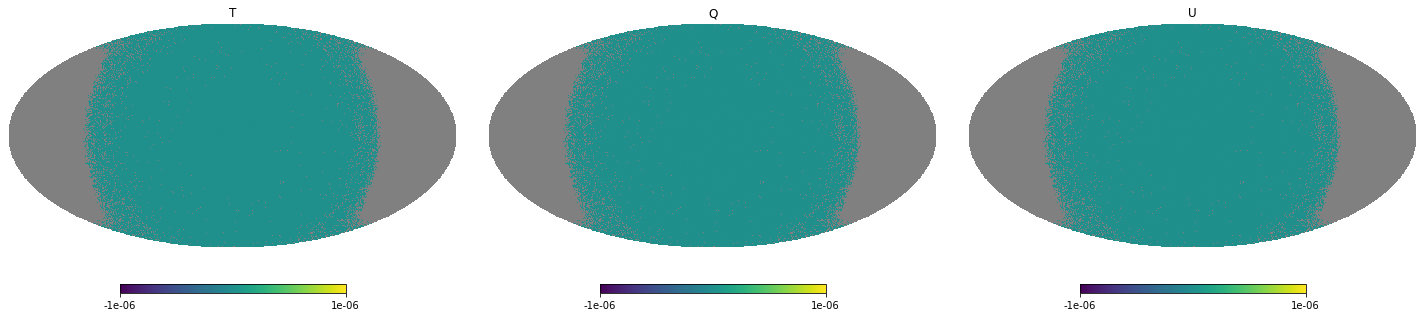

In [23]:
fig = plt.figure(figsize=(20,10))
hp.mollview(m[0]-maps[0],sub=131,title='T',min=-1e-6,max=1e-6)
hp.mollview(m[1]-maps[1],sub=132,title='Q',min=-1e-6,max=1e-6)
hp.mollview(m[2]-maps[2],sub=133,title='U',min=-1e-6,max=1e-6)